In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models
from datetime import datetime

In [2]:
def formatted_time(time_in_seconds):
    return("time taken for this epoch: ", datetime.fromtimestamp(time_in_seconds).strftime("%I:%M:%S"))

In [3]:
def data_loader(data_type, batch_size):
    data_path = 'data/'+ data_type + '/'  # data_type = train/test

    dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform =  transforms.Compose([transforms.Resize((299,299)), 
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        shuffle=True
    )
    return loader

In [4]:
def train(log_interval, model, device, train_loader, optimizer, epoch, criterion):
    model.train() # instructing pytorch that we want to train
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
#         loss = F.cross_entropy(output,target)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [5]:
def test(model, device, test_loader):
    model.eval() # instructing pytorch that we want to evaluate (and not train)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## set up hyperparameters

In [6]:
device = torch.device("cuda")
model=torchvision.models.resnet34(pretrained=True, progress=True )
# model.to(device)

batch_size = 16
train_loader = data_loader('train', batch_size )
test_loader = data_loader('test', batch_size )
epochs = 2
log_interval=100 # batches


In [7]:
model.fc = nn.Linear(in_features=512, out_features=2)
model = model.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [9]:
import time

start_time = time.time()
print('starting at: ',time.strftime('%Y-%m-%d %H:%M:%S'))

for epoch in range(1, epochs + 1):
    start_time_epoch = time.time()
    
    train(log_interval, model, device, train_loader, optimizer, epoch, criterion)
    test(model, device, test_loader)
    optimizer.step()
    
    end_time_epoch = time.time()
    total_time_this_epoch = end_time_epoch - start_time_epoch

    print('total time taken this epoch: ', formatted_time(total_time_this_epoch))

end_time = time.time()
print('ending  at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
print('total time taken: ', round(end_time-start_time,2), ' seconds')
total_time_taken = round(end_time-start_time)

print('total time taken for training: ', formatted_time(total_time_taken))

starting at:  2020-01-05 20:48:21
Train Epoch: 1 [0/24112 (0%)]	Loss: 0.763874
Train Epoch: 1 [1600/24112 (7%)]	Loss: 0.057507
Train Epoch: 1 [3200/24112 (13%)]	Loss: 0.009708
Train Epoch: 1 [4800/24112 (20%)]	Loss: 0.007083
Train Epoch: 1 [6400/24112 (27%)]	Loss: 0.051063
Train Epoch: 1 [8000/24112 (33%)]	Loss: 0.004030
Train Epoch: 1 [9600/24112 (40%)]	Loss: 0.078307
Train Epoch: 1 [11200/24112 (46%)]	Loss: 0.100795
Train Epoch: 1 [12800/24112 (53%)]	Loss: 0.004229
Train Epoch: 1 [14400/24112 (60%)]	Loss: 0.008481
Train Epoch: 1 [16000/24112 (66%)]	Loss: 0.002695
Train Epoch: 1 [17600/24112 (73%)]	Loss: 0.006510
Train Epoch: 1 [19200/24112 (80%)]	Loss: 0.175484
Train Epoch: 1 [20800/24112 (86%)]	Loss: 0.003272
Train Epoch: 1 [22400/24112 (93%)]	Loss: 0.017964
Train Epoch: 1 [24000/24112 (100%)]	Loss: 0.213736

Test set: Average loss: -4.7029, Accuracy: 438/444 (99%)

total time taken this epoch:  ('time taken for this epoch: ', '12:08:21')
Train Epoch: 2 [0/24112 (0%)]	Loss: 0.351560

In [10]:
torch.save(model, "catdog_resnet34.pt")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won'

# Let's predict

In [11]:
from PIL import Image
model.eval()

transforms =  transforms.Compose([transforms.Resize((299,299)), 
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def predict(image_path, model):
    image = Image.open(image_path)
    image_tensor = transforms(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    index = output.argmax().item()
    if index == 0:
        return "Cat"
    elif index == 1:
        return "Dog"
    else:
        return

'Dog'

Cat


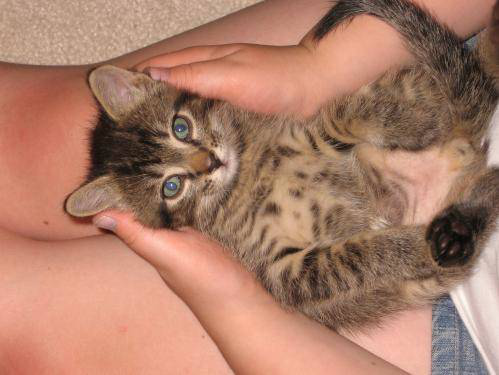

In [12]:
image_path = "./data/test1/6.jpg"
image = Image.open(image_path)
print(predict(image_path, model))
image

In [13]:
model_inference = torch.load('catdog_resnet34.pt')

In [29]:
from PIL import Image
model_inference.eval()
# transforms1 =  transforms.Compose([transforms.Resize((299,299)), 
#                                          transforms.ToTensor(),
#                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def predict_inference(image_path, model):
    image = Image.open(image_path)
    image_tensor = transforms(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    output = model_inference(image_tensor)
    index = output.argmax().item()
    if index == 0:
        return "Cat"
    elif index == 1:
        return "Dog"
    else:
        return

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs
tensor(1, device='cuda:0')
Dog


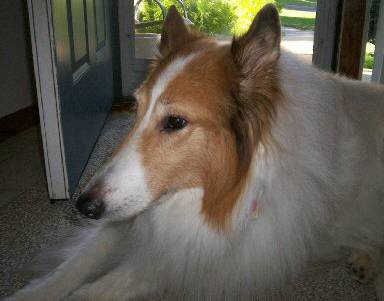

In [34]:
%time
image_path = "./data/test1/71.jpg"
image = Image.open(image_path)
print(predict_inference(image_path, model))
image

Dog


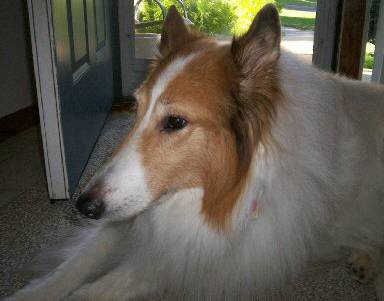

In [36]:
from PIL import Image
model_inference.eval()

image_path = "./data/test1/71.jpg"
image = Image.open(image_path)
image_tensor = transforms(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)
output = model_inference(image_tensor)
index = output.argmax().item()
if index == 0:
    print("Cat")
elif index == 1:
    print("Dog")

image

In [37]:
output

tensor([[-3.1816,  3.0080]], device='cuda:0', grad_fn=<AddmmBackward>)

In [45]:
val = torch.topk(output,2)

In [50]:
val

tensor([[1, 0]], device='cuda:0')